# Logistic Regression Hyperparameter Tuning

This notebook implements and tunes a Logistic Regression classifier for wildfire detection using NASA satellite measurement data.

In [3]:
# Standard library imports
import os

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.model_selection import train_test_split

# Configuration
DATA_PATH = "../data/final_combined_dataset.csv"
RANDOM_STATE = 1234
TEST_SIZE = 0.2

# Load dataset
data = pd.read_csv(DATA_PATH)

# Prepare features and target
X = data.drop(["FIRE", "Date"], axis=1)
y = data['FIRE']

# Split data into training and testing sets
X_train, X_test, y_train, y_test, data_train, data_test = train_test_split(
    X, y, data, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Display dataset shapes
print("Dataset splits:")
print(f"  Training set: {X_train.shape}")
print(f"  Test set:     {X_test.shape}")
print(f"\nLabel shapes:")
print(f"  Training labels: {y_train.shape}")
print(f"  Test labels:     {y_test.shape}")

Dataset splits:
  Training set: (23960, 12)
  Test set:     (5990, 12)

Label shapes:
  Training labels: (23960,)
  Test labels:     (5990,)


,name,Training Accuracy,Eval Accuracy,Training Recall,Eval Recall,Training Precision,Eval Precision,Training F1,Eval F1,Training ROC,Eval ROC
0,Logistic Regression,0.946035,0.945409,0.9573,0.955041,0.936487,0.934978,0.946779,0.944903,0.985928,0.984833


Generating visualizations for Logistic Regression...


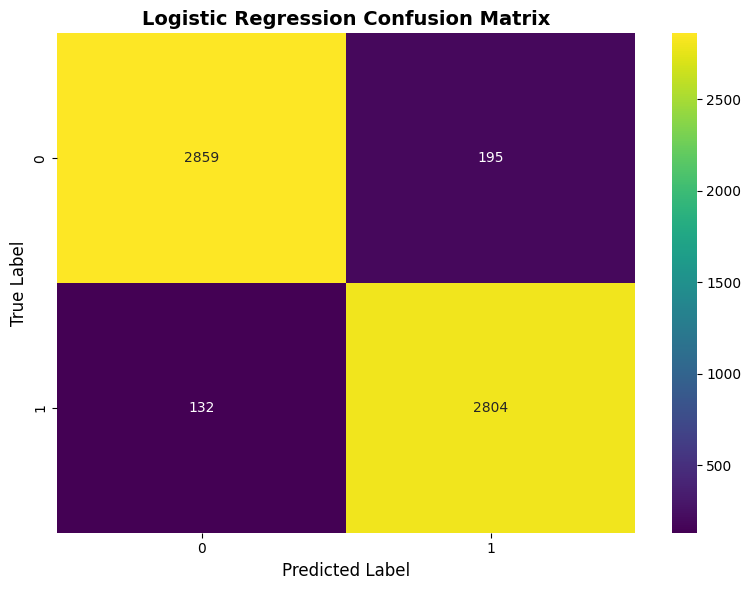

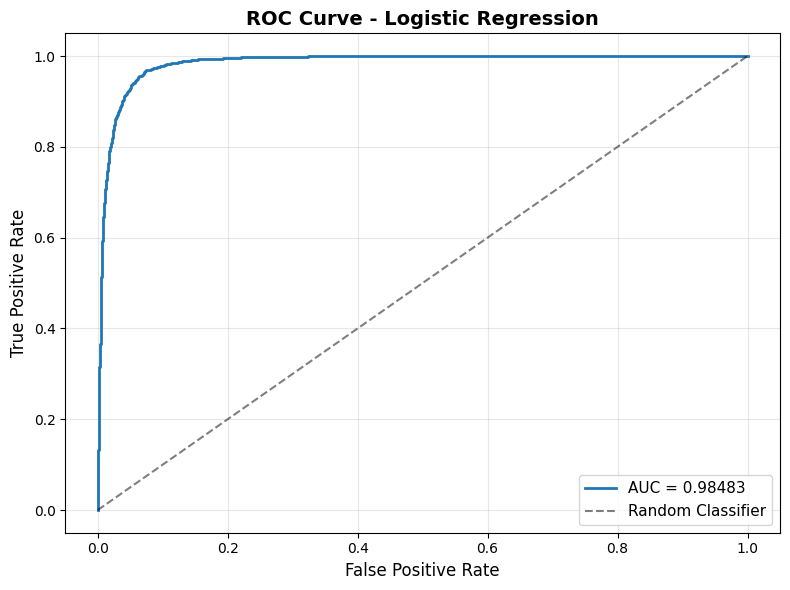

In [4]:
# Scikit-learn imports
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)


def evaluate_pipelines(pipelines, X_train, y_train, X_evaluate, y_evaluate):

    rows = []
    for name, pipeline in pipelines:
        # Fit pipeline on training data
        pipeline.fit(X_train, y_train)
        
        # Generate predictions
        train_preds = pipeline.predict(X_train)
        eval_preds = pipeline.predict(X_evaluate)
        
        # Get probabilities for ROC-AUC calculation
        train_probs = pipeline.predict_proba(X_train)[:, 1]
        eval_probs = pipeline.predict_proba(X_evaluate)[:, 1]
        
        # Calculate metrics
        rows.append({
            'name': name,
            'Training Accuracy': accuracy_score(y_train, train_preds),
            'Eval Accuracy': accuracy_score(y_evaluate, eval_preds),
            'Training Recall': recall_score(y_train, train_preds),
            'Eval Recall': recall_score(y_evaluate, eval_preds),
            'Training Precision': precision_score(y_train, train_preds),
            'Eval Precision': precision_score(y_evaluate, eval_preds),
            'Training F1': f1_score(y_train, train_preds),
            'Eval F1': f1_score(y_evaluate, eval_preds),
            'Training ROC': roc_auc_score(y_train, train_probs),
            'Eval ROC': roc_auc_score(y_evaluate, eval_probs)
        })
    
    return pd.DataFrame(rows)


def plot_confusion_matrix(y_true, y_pred, clf_name):

    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='viridis')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(f'{clf_name} Confusion Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def plot_roc_curve(y_true, y_probs, clf_name=""):

    auc = roc_auc_score(y_true, y_probs)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.5f}", linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    title = f"ROC Curve - {clf_name}" if clf_name else "ROC Curve"
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# Initialize baseline Logistic Regression model
logistic_regression = make_pipeline(
    LogisticRegression(random_state=RANDOM_STATE, max_iter=10000)
)

# Evaluate baseline model
baseline_results = evaluate_pipelines(
    [('Logistic Regression', logistic_regression)],
    X_train, y_train, X_test, y_test
)
display(baseline_results)

# Generate visualizations
print("Generating visualizations for Logistic Regression...")
logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_test)
y_probs = logistic_regression.predict_proba(X_test)[:, 1]
plot_confusion_matrix(y_test, y_pred, "Logistic Regression")
plot_roc_curve(y_test, y_probs, "Logistic Regression")

## Hyperparameter Tuning

Tune Logistic Regression based on the following parameters:
- C (regularization strength)
- tol (tolerance)

Utilize Cross-Validation for hyperparameter tuning

Performing grid search for Logistic Regression...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Parameters: {'C': 0.0775, 'tol': 0.001}
Best CV Score: 0.985713


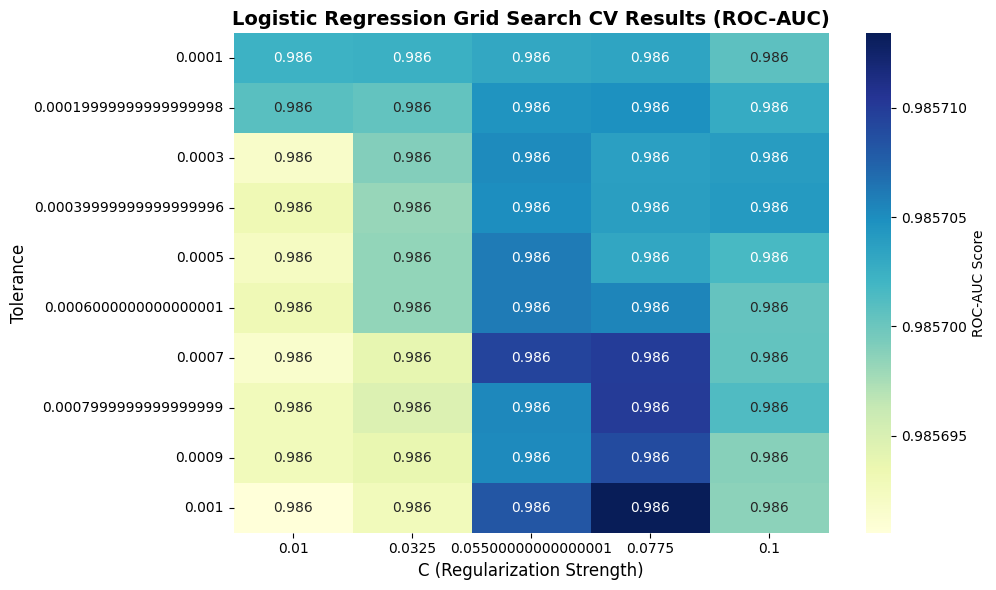

In [5]:
# Hyperparameter tuning for Logistic Regression
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Logistic Regression
lr_param_grid = {
    'tol': np.linspace(0.0001, 0.001, num=10, dtype=float),
    'C': np.linspace(0.01, 0.1, num=5, dtype=float)
}

# Perform grid search with 5-fold cross-validation
lr_grid_search = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    param_grid=lr_param_grid,
    cv=5,
    scoring='roc_auc_ovo',
    n_jobs=-1,
    verbose=1
)

print("Performing grid search for Logistic Regression...")
lr_grid_search.fit(X_train, y_train)

# Display best parameters
print(f"\nBest Parameters: {lr_grid_search.best_params_}")
print(f"Best CV Score: {lr_grid_search.best_score_:.6f}")

# Visualize grid search results
results_df = pd.DataFrame(lr_grid_search.cv_results_)
pivot_table = results_df.pivot_table(
    values='mean_test_score',
    index='param_tol',
    columns='param_C'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={'label': 'ROC-AUC Score'})
plt.title('Logistic Regression Grid Search CV Results (ROC-AUC)', fontsize=14, fontweight='bold')
plt.xlabel('C (Regularization Strength)', fontsize=12)
plt.ylabel('Tolerance', fontsize=12)
plt.tight_layout()
plt.show()

## Final Evaluation

Compare base and tuned Logistic Regression models.

Comparing base and tuned Logistic Regression models:


,name,Training Accuracy,Eval Accuracy,Training Recall,Eval Recall,Training Precision,Eval Precision,Training F1,Eval F1,Training ROC,Eval ROC
0,Base Logistic Regression,0.946035,0.945409,0.95730,0.955041,0.936487,0.934978,0.946779,0.944903,0.985928,0.984833
1,Tuned Logistic Regression,0.946077,0.945409,0.95755,0.955041,0.936350,0.934978,0.946831,0.944903,0.985920,0.984816



Generating visualizations for Base Logistic Regression...


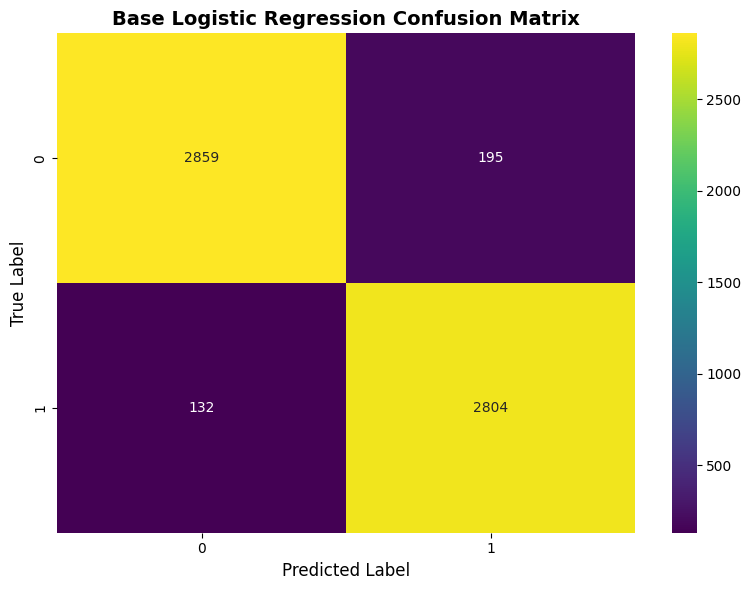

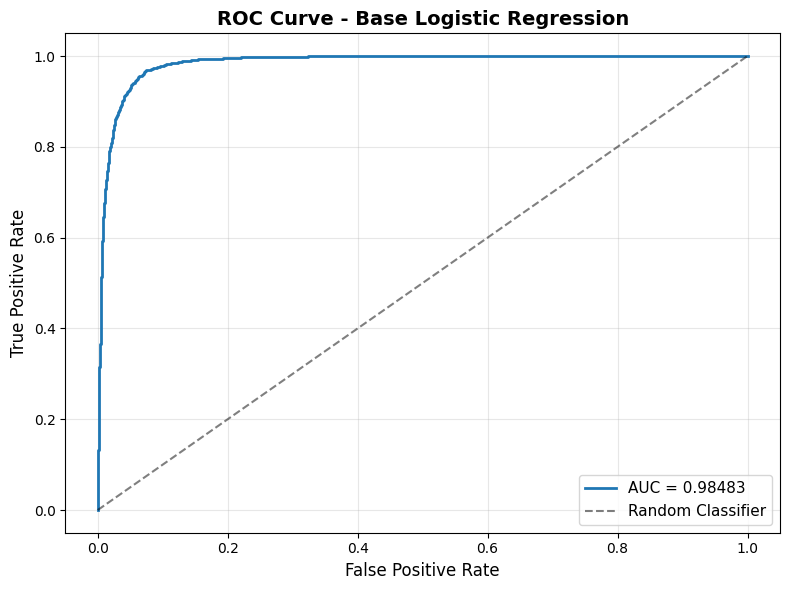


Generating visualizations for Tuned Logistic Regression...


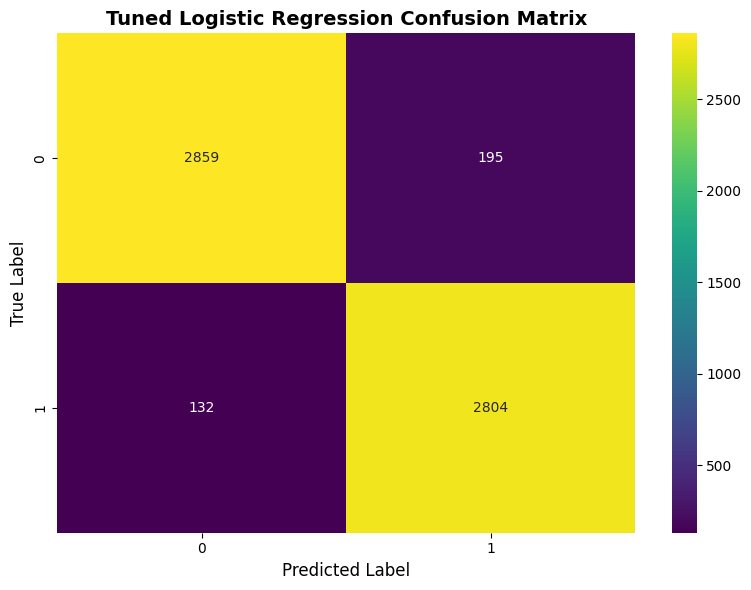

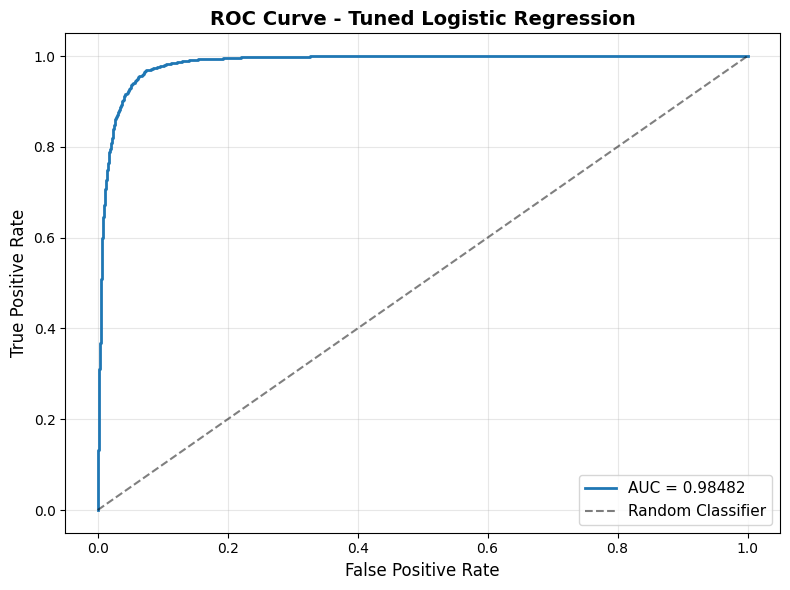

In [6]:
# Extract best hyperparameters
LR_BEST_C = lr_grid_search.best_params_['C']
LR_BEST_TOL = lr_grid_search.best_params_['tol']

# Create base and tuned models
base_lr = make_pipeline(LogisticRegression(random_state=RANDOM_STATE, max_iter=10000))
tuned_lr = make_pipeline(LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=10000,
    C=LR_BEST_C,
    tol=LR_BEST_TOL
))

# Evaluate models
print("Comparing base and tuned Logistic Regression models:")
comparison_results = evaluate_pipelines([
    ('Base Logistic Regression', base_lr),
    ('Tuned Logistic Regression', tuned_lr)
], X_train, y_train, X_test, y_test)
display(comparison_results)

# Generate visualizations
models_to_plot = [
    ('Base Logistic Regression', base_lr),
    ('Tuned Logistic Regression', tuned_lr)
]

for name, clf in models_to_plot:
    print(f"\nGenerating visualizations for {name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_probs = clf.predict_proba(X_test)[:, 1]
    plot_confusion_matrix(y_test, y_pred, name)
    plot_roc_curve(y_test, y_probs, name)

## Scaling and Hyperparameter Tuning

Evaluate the impact of feature scaling on Logistic Regression performance.

Comparing base and scaled Logistic Regression models:


,name,Training Accuracy,Eval Accuracy,Training Recall,Eval Recall,Training Precision,Eval Precision,Training F1,Eval F1,Training ROC,Eval ROC
0,Base Logistic Regression,0.946035,0.945409,0.957300,0.955041,0.936487,0.934978,0.946779,0.944903,0.985928,0.984833
1,Scaled Logistic Regression,0.945618,0.941569,0.958215,0.953338,0.934947,0.929283,0.946438,0.941157,0.985203,0.983618



Generating visualizations for Base Logistic Regression...


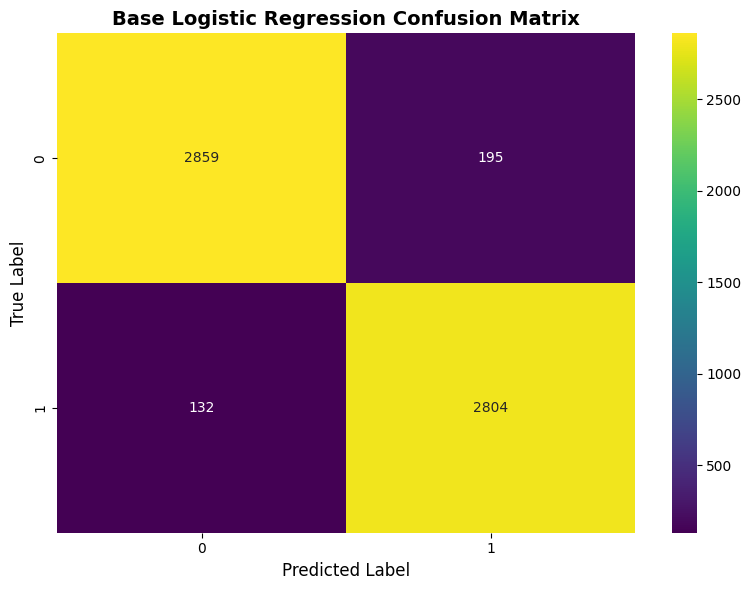

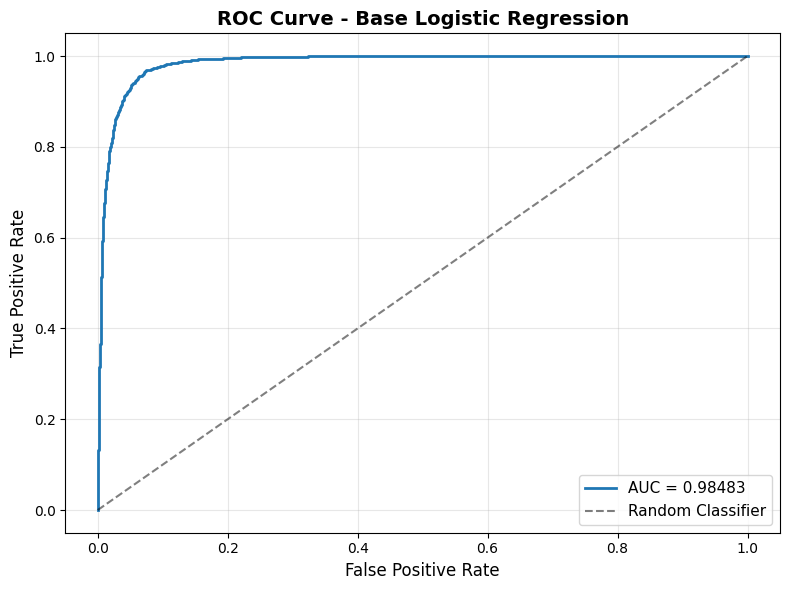


Generating visualizations for Scaled Logistic Regression...


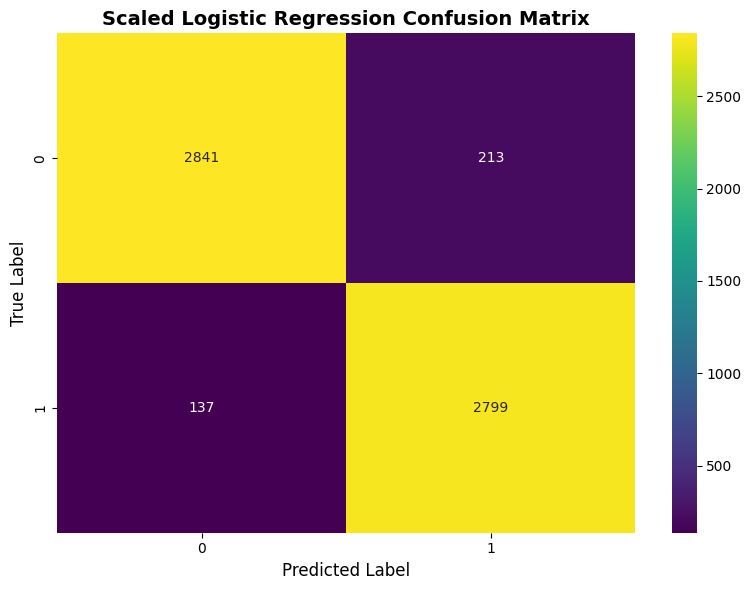

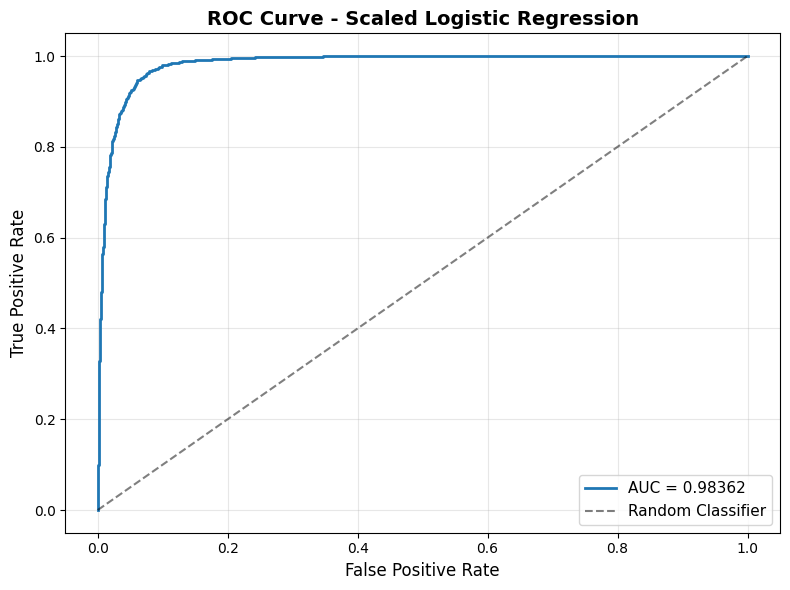

In [7]:
# Evaluate impact of feature scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Create base and scaled models
base_lr = make_pipeline(LogisticRegression(random_state=RANDOM_STATE, max_iter=10000))
scaled_lr = make_pipeline(scaler, LogisticRegression(random_state=RANDOM_STATE, max_iter=10000))

# Evaluate models
print("Comparing base and scaled Logistic Regression models:")
scaling_results = evaluate_pipelines([
    ('Base Logistic Regression', base_lr),
    ('Scaled Logistic Regression', scaled_lr)
], X_train, y_train, X_test, y_test)
display(scaling_results)

# Generate visualizations
models_to_plot = [
    ('Base Logistic Regression', base_lr),
    ('Scaled Logistic Regression', scaled_lr)
]

for name, clf in models_to_plot:
    print(f"\nGenerating visualizations for {name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_probs = clf.predict_proba(X_test)[:, 1]
    plot_confusion_matrix(y_test, y_pred, name)
    plot_roc_curve(y_test, y_probs, name)

## Scaled and Tuned Model

Combine feature scaling with hyperparameter tuning.

Comparing all Logistic Regression model variants:


,name,Training Accuracy,Eval Accuracy,Training Recall,Eval Recall,Training Precision,Eval Precision,Training F1,Eval F1,Training ROC,Eval ROC
0,Base Logistic Regression,0.946035,0.945409,0.957300,0.955041,0.936487,0.934978,0.946779,0.944903,0.985928,0.984833
1,Scaled Logistic Regression,0.945618,0.941569,0.958215,0.953338,0.934947,0.929283,0.946438,0.941157,0.985203,0.983618
2,Scaled and Tuned Logistic Regression,0.940192,0.934891,0.962960,0.956744,0.921319,0.914388,0.941679,0.935087,0.983225,0.981199



Generating visualizations for Base Logistic Regression...


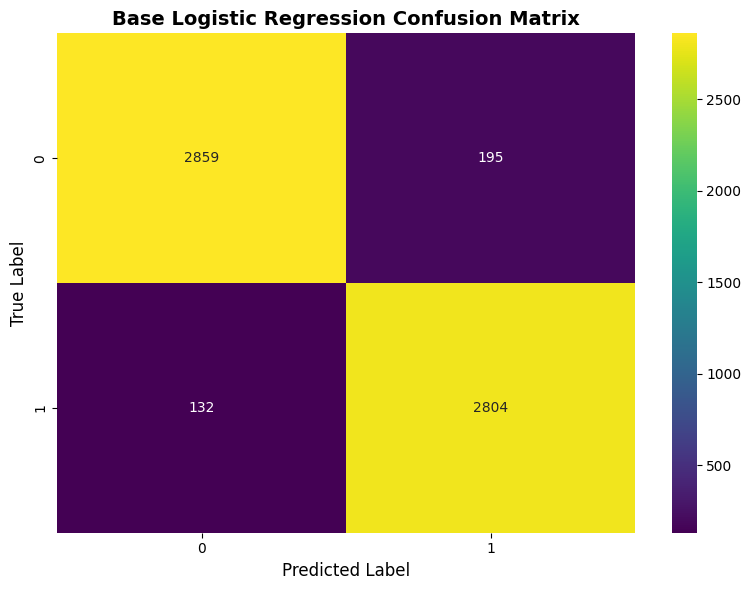

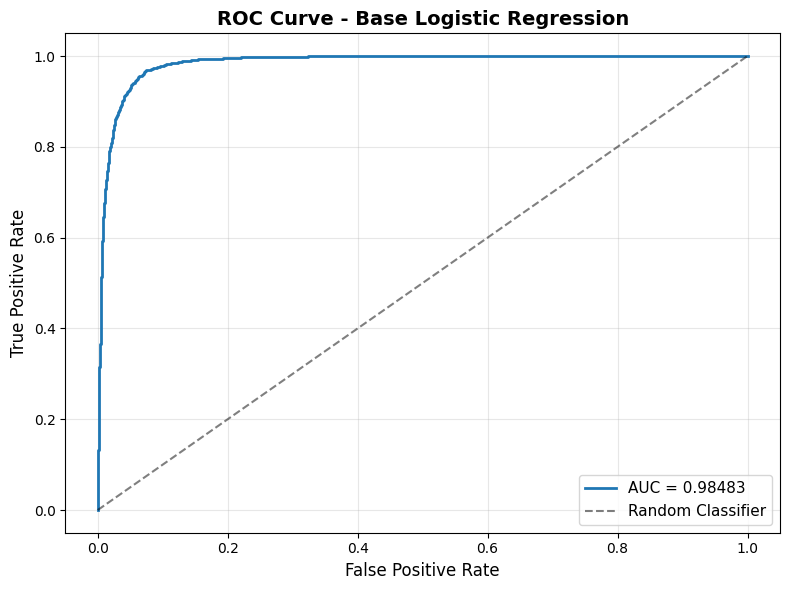


Generating visualizations for Scaled Logistic Regression...


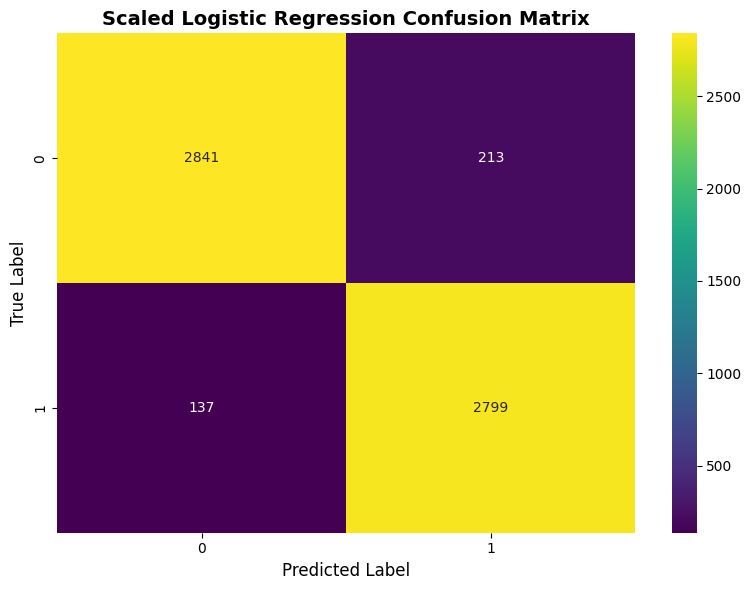

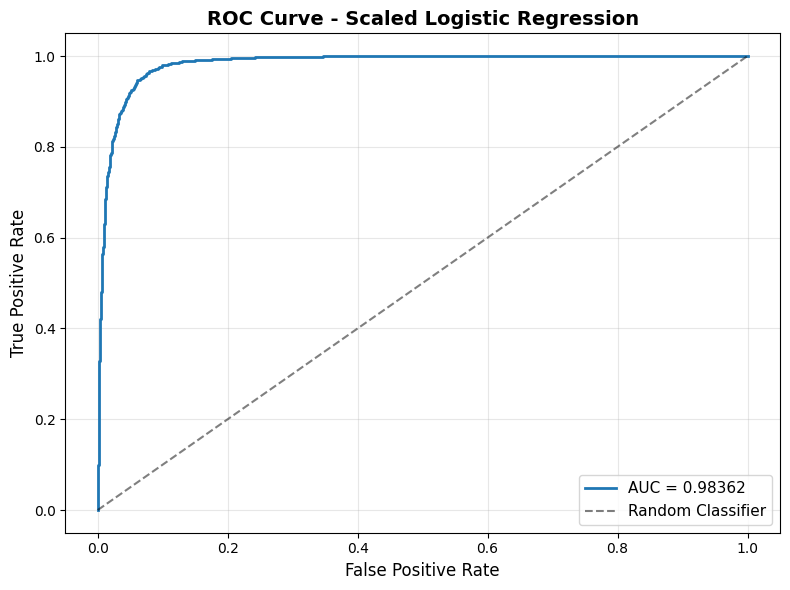


Generating visualizations for Scaled and Tuned Logistic Regression...


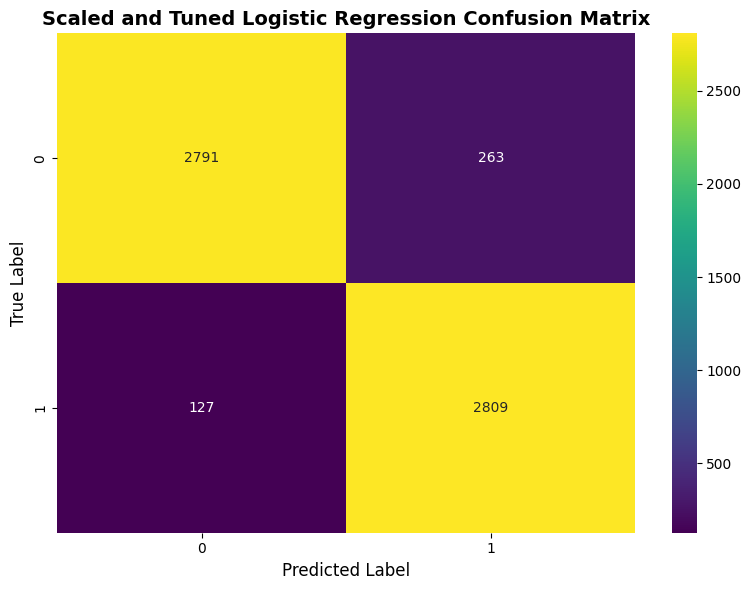

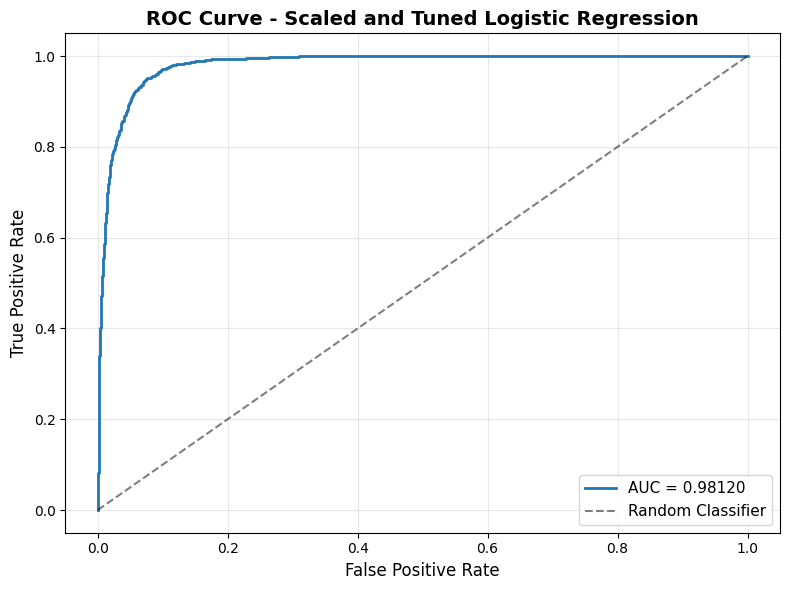

In [8]:
# Create scaled and tuned model
tuned_lr = make_pipeline(
    scaler,
    LogisticRegression(
        random_state=RANDOM_STATE,
        max_iter=10000,
        C=LR_BEST_C,
        tol=LR_BEST_TOL
    )
)

# Evaluate all model variants
print("Comparing all Logistic Regression model variants:")
final_results = evaluate_pipelines([
    ('Base Logistic Regression', base_lr),
    ('Scaled Logistic Regression', scaled_lr),
    ('Scaled and Tuned Logistic Regression', tuned_lr)
], X_train, y_train, X_test, y_test)
display(final_results)

# Generate visualizations for all models
models_to_plot = [
    ('Base Logistic Regression', base_lr),
    ('Scaled Logistic Regression', scaled_lr),
    ('Scaled and Tuned Logistic Regression', tuned_lr)
]

for name, clf in models_to_plot:
    print(f"\nGenerating visualizations for {name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_probs = clf.predict_proba(X_test)[:, 1]
    plot_confusion_matrix(y_test, y_pred, name)
    plot_roc_curve(y_test, y_probs, name)

## Summary

Using cross-validation to tune the hyperparameters of the Logistic Regression model, we note improvements in the ROC-AUC score. The tuned model shows enhanced performance for wildfire risk prediction, which is our main goal for forecasting risk levels for wildfire outbreak.

## Feature Importance

In [9]:
# Feature importance analysis using permutation importance
from sklearn.inspection import permutation_importance

# Calculate permutation importance for Logistic Regression
print("Calculating permutation importance for Logistic Regression...")
lr_perm = permutation_importance(
    estimator=tuned_lr,
    X=X_test,
    y=y_test,
    n_repeats=15,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Format results as DataFrame
lr_perm_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': lr_perm.importances_mean,
    'Std': lr_perm.importances_std
}).sort_values('Importance', ascending=False)

print("\nLogistic Regression Feature Importance:")
print("=" * 60)
display(lr_perm_df)

Calculating permutation importance for Logistic Regression...

Logistic Regression Feature Importance:


,Feature,Importance,Std
8,PS,0.387152,0.007675
0,Latitude,0.018407,0.000885
7,RH2M,0.005835,0.000709
1,Longitude,0.003209,0.000487
6,T2MDEW,0.002527,0.000311
4,T2M_MAX,0.001756,0.000321
3,T2M,0.001175,0.000253
5,T2M_MIN,0.000568,0.000170
2,WS2M,0.000019,0.000083
10,ALLSKY_SFC_SW_DWN,0.000013,0.000005


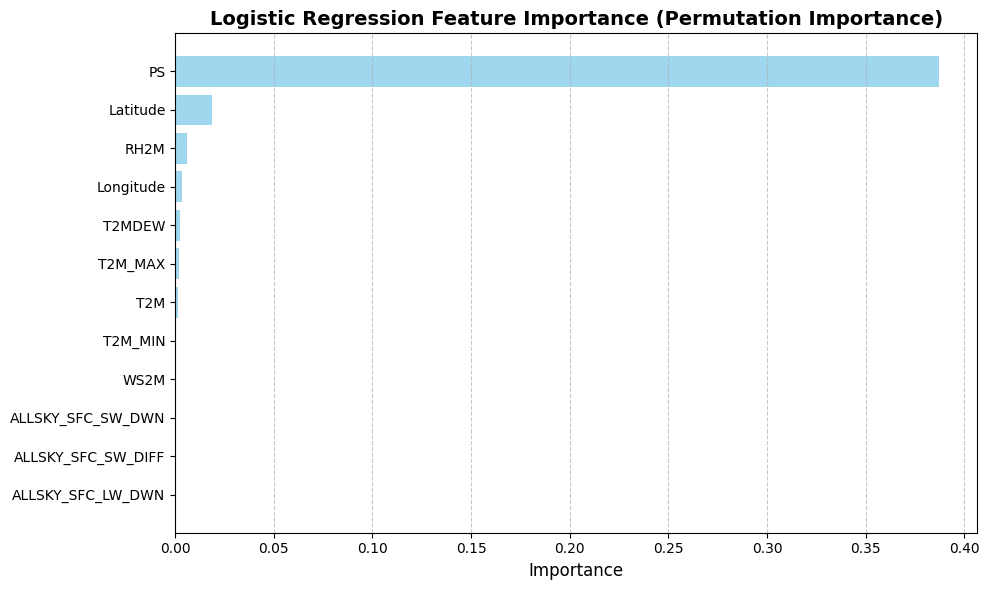

In [10]:
# Visualize Logistic Regression feature importance
plt.figure(figsize=(10, 6))
plt.barh(lr_perm_df['Feature'], lr_perm_df['Importance'], color='skyblue', alpha=0.8)
plt.xlabel('Importance', fontsize=12)
plt.title('Logistic Regression Feature Importance (Permutation Importance)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Most important at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()